In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import math


In [2]:
# params
seed = 42

Данные по 50-ти корпоративным заемщикам. В качестве фактора - financial ratios.


In [6]:
#read the data
df = pd.read_excel('bankruptcy.xls')

df.head()

,Company,WC/TA,RE/TA,EBIT/TA,S/TA,BVE/BVL,Bankrupt
0,360Networks,9.3,-7.7,1.6,9.1,3.726,1
1,Advanced Radio Telecom,42.6,-60.1,-10.1,0.3,4.130,1
2,Ardent Communications,-28.8,-203.2,-51.0,14.7,0.111,1
3,At Home Corp.,2.5,-433.1,-6.0,29.3,1.949,1
4,Convergent Communications,26.1,-57.4,-23.5,54.2,0.855,1


Уже видим пропуски

### Список факторов:
|    | Variable Name   | Description                         | Codings                                                 |
|---:|:----------------|:------------------------------------|:--------------------------------------------------------|
|  0 | Bankrupt             | target                              |  |
|  1 | S/TA                | Sales to total assets                                    |                                  |
|  2 | EBIT/TA            | Earnings before interest and tax to total assets          |                                                         |
|  3 | RE/TA         | Retained earnings to total assets     |                                                         |
|  4 | WC/TA           | Working capital to total assets           |                                                         |
|  5 | BVE/BVL           | Book value of equity to book value of liabilities           |                                                         |

In [22]:
df_names = pd.DataFrame({"Variable Name" : ["Bankrupt", "S/TA", "EBIT/TA", "RE/TA", "WC/TA", "BVE/BVL"],
                        "Description" : ["target", "Sales to total assets", "Earnings before interest and tax to total assets", 
                                         "Retained earnings to total assets", "Working capital to total assets",
                                         "Book value of equity to book value of liabilities"]})
df_names

,Variable Name,Description
0,Bankrupt,target
1,S/TA,Sales to total assets
2,EBIT/TA,Earnings before interest and tax to total assets
3,RE/TA,Retained earnings to total assets
4,WC/TA,Working capital to total assets
5,BVE/BVL,Book value of equity to book value of liabilities


Датасет поделен пополам между дефолтнувшими и недефолтнувшими заемщиками

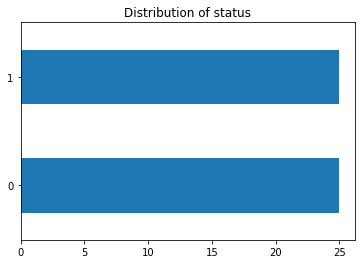

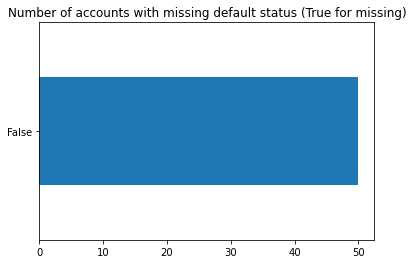

In [8]:
df.Bankrupt.value_counts().plot.barh()
plt.title("Distribution of status")
plt.show()

df.Bankrupt.isnull().value_counts().plot.barh()
plt.title("Number of accounts with missing default status (True for missing)")
plt.show()

Для единообразия нотации, создадим новую зависимую переменную target:

In [29]:
df.rename(columns = {"Bankrupt":"target"}, inplace = True)
df.drop(columns = ["Company"], inplace = True)

Выделяем test&train сеты

In [30]:
X = df.loc[:, df.columns != 'target']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [ ]:
!pip install pyarrow
!pip install fastparquet

In [31]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

In [32]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество наблюдений, где имеются данные о дефолте или его отсутствии: {X[y.isnull() == False].shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X[y.isnull() == False].shape[0] * 100}%')

Количество наблюдений: 50
Количество наблюдений, где имеются данные о дефолте или его отсутствии: 50
Количество факторов: 5
Количество целевых событий: 25
Доля целевых событий: 50.0%


### Пропуски

В датасете присутствуют пропуски (но не в зависимой переменной)

In [33]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору WC/TA:
	0 или 0.0%
Количество пропусков по фактору RE/TA:
	0 или 0.0%
Количество пропусков по фактору EBIT/TA:
	0 или 0.0%
Количество пропусков по фактору S/TA:
	0 или 0.0%
Количество пропусков по фактору BVE/BVL:
	0 или 0.0%


### Визуальный анализ

Изготовим маску для осмысленного наименования факторов:

In [34]:
from pprint import pprint 
df_names_short = df_names[["Variable Name", "Description"]][(df_names["Variable Name"] != "")&(df_names["Description"] != "")]
short_names = df_names_short["Variable Name"]
short_names = short_names.str.upper()
meaningful_names = df_names_short["Description"]
names_mask = dict(zip(short_names, meaningful_names))

pprint(names_mask)

{'BANKRUPT': 'target',
 'BVE/BVL': 'Book value of equity to book value of liabilities',
 'EBIT/TA': 'Earnings before interest and tax to total assets',
 'RE/TA': 'Retained earnings to total assets',
 'S/TA': 'Sales to total assets',
 'WC/TA': 'Working capital to total assets'}


И маски для осмысленных обозначений кодов категориальных переменных:

In [26]:

cat_vals_reason_mask = {
    "DebtCon" : ""
}

dict_of_masks = {
}

In [35]:
X_cat = X.copy()
for col_name in dict_of_masks.keys():
    X_cat[col_name] = X_cat[col_name].replace(dict_of_masks[col_name])

numeric


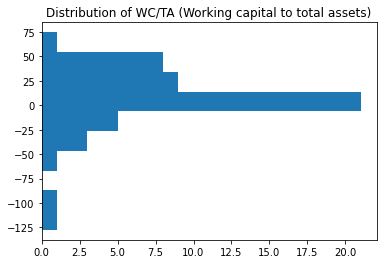

numeric


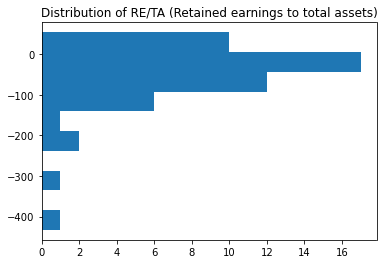

numeric


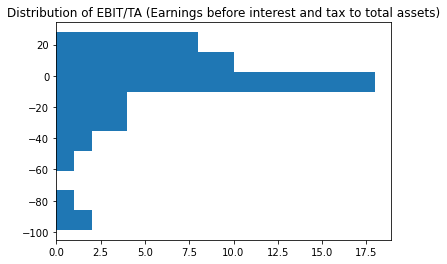

numeric


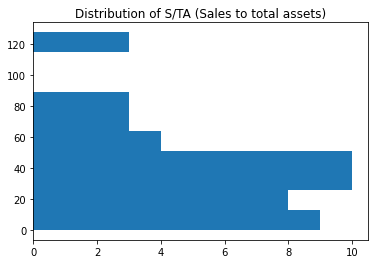

numeric


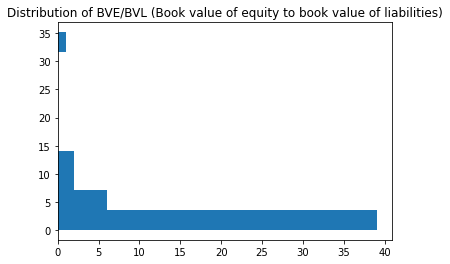

In [36]:
def plot_categorical(column, column_name, names_mask):
    column.value_counts().plot.barh()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_mixed(column, column_name, names_mask):
    print("This is a column mixed of both numeric and non-numeric values")
    check_numeric = column.str.isnumeric()
    check_numeric[check_numeric.isnull()] = True
    check_numeric[column.isnull()] = False

    plt.hist(column[check_numeric], orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]}) without non-numeric values')
    plt.show()

    check_numeric.value_counts().plot.barh()
    plt.title(f'Distribution of non-missing (numeric) values in {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_numeric(column, column_name, names_mask):
    plt.hist(column, orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()    

def plot_datetime(column, column_name, names_mask):
    column.hist()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()
    
def check_mixed_or_categorical(column):
    if is_string_dtype(column) == False:
        return(False)
    else:
        check_numeric = column.str.isnumeric()
        check_numeric[check_numeric.isnull()] = True
        check_numeric[column.isnull()] = False
        if len(column[check_numeric]) == 0:
            return("categorical")
        else:
            return("mixed")

def check_factor_plotting_type(column, column_name, names_mask):
    if column.dtype == pd.Series([np.datetime64("1995-05-05")]).dtype:
        return("datetime")
    elif check_mixed_or_categorical(column) != False:
        return(check_mixed_or_categorical(column))
    else:
        return("numeric")

def plot_all(column, column_name, names_mask, presumably_discrete_names = presumably_discrete_names):
    map_functions_to_types = {
        "categorical" : plot_categorical,
        "mixed" : plot_mixed,
        "numeric" : plot_numeric, 
        "datetime" : plot_datetime
    }
    
    type_checked = check_factor_plotting_type(column, column_name, names_mask)
    print(type_checked)
    map_functions_to_types[type_checked](column, column_name, names_mask)


for col in X_cat.columns:
    
    plot_all(X_cat[col], col, names_mask)


Распределение переменных выглядит ок, хотя имеется странная вторая мода у BVE/BVL. Выбросов незаметно, хотя сложно о них судить для такого числа наблюдений.


### Выводы

Датасет очень маленький. Естественно, в нем нет пропусков и сложно сказать что-то о выбросах.